In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

# Function to load and preprocess images from a directory
def load_images_and_labels(directory, csv_path, image_size):
    images = []
    labels = []

    # Load labels from CSV file
    df = pd.read_csv(csv_path)
    df['filename'] = df['filename'].apply(lambda x: os.path.join(directory, x))

    for index, row in df.iterrows():
        img_path = row['filename']

        if not os.path.exists(img_path):
            print(f"Warning: Image file not found - {img_path}")
            continue

        # Check if the file has a valid image extension (.png or .jpg)
        if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Unable to read image - {img_path}")
                continue

            img = cv2.resize(img, (image_size, image_size))
            images.append(img)
            labels.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        else:
            print(f"Warning: Skipped non-image file - {img_path}")

    return np.array(images), np.array(labels)

# Load training data
image_size = 128  # Adjust as needed
train_images, train_labels = load_images_and_labels('/content/drive/MyDrive/archive (2)/train', '/content/drive/MyDrive/archive (2)/train_labels.csv', image_size)

# Load validation data
validation_images, validation_labels = load_images_and_labels('/content/drive/MyDrive/archive (2)/validation', '/content/drive/MyDrive/archive (2)/validation_labels.csv', image_size)

# Data Splitting
train_images, validation_images, train_labels, validation_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Model Definition
model = tf.keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(4)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Batch Size
batch_size = 32

# ModelCheckpoint callback to save the best model
checkpoint_callback = ModelCheckpoint("best_model1.h5", save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# Normalize pixel values
train_images_normalized = train_images / 255.0
validation_images_normalized = validation_images / 255.0

# Model Training with Data Augmentation
history = model.fit(datagen.flow(train_images_normalized, train_labels, batch_size=batch_size),
                    epochs=50,  # Adjust the number of epochs
                    validation_data=(validation_images_normalized, validation_labels),
                    callbacks=[checkpoint_callback])

# Evaluate the model on the validation set
validation_predictions = model.predict(validation_images_normalized)

# Calculate Mean Squared Error for bounding box coordinates
validation_mse = np.mean((validation_predictions - validation_labels) ** 2)
print(f'Validation Mean Squared Error: {validation_mse}')

# Save the trained model
model.save("final_model1.h5")
print("Model saved successfully.")


Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 14238.4863
Epoch 1: val_loss improved from inf to 13431.43848, saving model to best_model1.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 14s 2s/step - loss: 14238.4863 - val_loss: 13431.4385
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 11061.6914
Epoch 2: val_loss improved from 13431.43848 to 9443.91309, saving model to best_model1.h5
4/4 [==============================] - 5s 2s/step - loss: 11061.6914 - val_loss: 9443.9131
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 7361.9492
Epoch 3: val_loss improved from 9443.91309 to 5263.58691, saving model to best_model1.h5
4/4 [==============================] - 5s 2s/step - loss: 7361.9492 - val_loss: 5263.5869
Epoch 4/50
4/4 [==============================] - ETA: 0s - loss: 3734.0020
Epoch 4: val_loss improved from 5263.58691 to 2495.96631, saving model to best_model1.h5
4/4 [==============================] - 9s 3s/step - loss: 3734.0020 - val_loss: 2495.9663
Epoch 5/50
4/4 [==============================] - ETA: 0s - loss: 2281.5632
Epoch 5: val_loss did not improve from 2495.96631
4/4 [========

1/1 [==============================] - 0s 59ms/step


<ipython-input-20-682579aa0a19>:53: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im.thumbnail((128, 128), Image.ANTIALIAS)


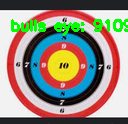

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from PIL import Image

model_path = '/content/best_model1.h5'
classes = ['bulls eye']
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.uint8)
    original_image = img
    resized_img = tf.image.resize(img, (input_size, input_size))  # Updated input_size here
    resized_img = resized_img[tf.newaxis, :]
    resized_img = tf.cast(resized_img, dtype=tf.uint8)
    return resized_img, original_image

def detect_objects(model, image, threshold):
    predictions = model.predict(image)
    results = []

    for i in range(predictions.shape[0]):
        score = predictions[i]
        if np.any(score >= threshold):  # Use np.any() for element-wise comparison
            result = {
                'score': score
            }
            results.append(result)

    return results


def run_odt_and_draw_results(image_path, model, threshold=0.5):
    input_size = 128  # Update to the correct input size
    preprocessed_image, original_image = preprocess_image(image_path, input_size)
    results = detect_objects(model, preprocessed_image, threshold=threshold)
    original_image_np = original_image.numpy().astype(np.uint8)

    for obj in results:
        label = f'{classes[0]}: {obj["score"][0]:.0%}'
        cv2.putText(original_image_np, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return original_image_np

# Load the Keras Sequential model
model = tf.keras.models.load_model(model_path)

# Example usage
TEMP_FILE = '/content/drive/MyDrive/archive (2)/test/bullseye target with points (350).jpg'
im = Image.open(TEMP_FILE)
im.thumbnail((128, 128), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')
detection_result_image = run_odt_and_draw_results(TEMP_FILE, model, threshold=0.5)
Image.fromarray(detection_result_image)


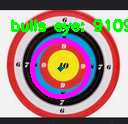

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image

def main(image_array):
    # Check if the image is loaded fine
    if image_array is None:
        print('Error opening image!!')
        print('Usage: hough_circle.py [image_name]')
        return -1

    # Convert to grayscale
    gray = tf.image.rgb_to_grayscale(image_array)

    # Convert to numpy array
    gray_np = np.array(gray)

    # Apply median blur
    gray_np = cv2.medianBlur(gray_np, 5)

    # Get the shape of the image
    rows = gray_np.shape[0]

    # HoughCircles
    circles = cv2.HoughCircles(
        gray_np,
        cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=int(rows / 8),
        param1=100,
        param2=30,
        minRadius=1,
        maxRadius=30
    )

    if circles is not None:
        circles = np.uint16(np.around(circles))

        for i in circles[0, :]:
            center = (i[0], i[1])

            # Circle center
            cv2.circle(image_array, center, 1, (0, 100, 100), 3)

            # Circle outline
            radius = i[2]
            cv2.circle(image_array, center, radius, (255, 0, 255), 3)

    return image_array

# Assuming detection_result_image is the result from the object detection
# process that you want to apply HoughCircles on.
main_result = main(detection_result_image)
Image.fromarray(main_result)
